{/* cspell:ignore interpretability hyperparameters overfitting sublinear preds prec */}
# Hybrid quantum-enhanced ensemble classification (grid stability workflow)

*Usage estimate: 60 minutes for each job on an Eagle r3 processor. (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

This tutorial demonstrates a hybrid quantum–classical workflow that enhances a classical ensemble with a quantum optimization step. Using Multiverse Computing’s “Singularity Machine Learning – Classification” (a Qiskit Function), we train a pool of conventional learners (for example, decision trees, k-NN, logistic regression) and then refine that pool with a quantum layer to improve diversity and generalization. The objective is practical: on a real grid-stability prediction task, we compare a strong classical baseline with a quantum-optimized alternative under the same data splits, so you can see where the quantum step helps and what it costs.

Why this matters: selecting a good subset from many weak learners is a combinatorial problem that grows quickly with ensemble size. Classical heuristics like boosting, bagging, and stacking perform well at moderate scales but can struggle to explore large, redundant libraries of models efficiently. The function integrates quantum algorithms - specifically QAOA (and optionally VQE in other configurations) - to search that space more effectively after the classical learners are trained, increasing the chance of finding a compact, diverse subset that generalizes better.

Crucially, data scale is not limited by qubits. The heavy lifting on data — preprocessing, training the learner pool, and evaluation — remains classical and can handle millions of examples. Qubits only determine the ensemble size used in the quantum selection step. This decoupling is what makes the approach viable on today’s hardware: you keep familiar scikit-learn workflows for data and model training while calling the quantum step through a clean action interface in Qiskit Functions. 

In practice, while different learner types can be provided to the ensemble (e.g., decision trees, logistic regression, or k-NN), Decision Trees tend to perform best. The optimizer consistently favors stronger ensemble members—when heterogeneous learners are supplied, weaker models such as linear regressors are typically pruned in favor of more expressive ones like Decision Trees.

What you will do here: prepare and balance the grid-stability dataset; establish a classical AdaBoost baseline; run several quantum configurations that vary ensemble width and regularization; execute on IBM&reg; simulators or QPUs via Qiskit Serverless; and compare accuracy, precision, recall, and F1 across all runs. Along the way, you will use the function’s action pattern (`create`, `fit`, `predict`, `fit_predict`, `create_fit_predict`) and key controls:
- Regularization types: `onsite` (λ) for direct sparsity and `alpha` for a ratio-based trade-off between interaction and onsite terms
- Auto-regularization: set `regularization="auto"` with a target selection ratio to adapt sparsity automatically
- Optimizer options: simulator versus QPU, repetitions, classical optimizer and its options, transpilation depth, and runtime sampler/estimator settings

Benchmarks in the documentation show that accuracy improves as the number of learners (qubits) increases on challenging problems, with the quantum classifier matching or exceeding a comparable classical ensemble. In this tutorial, you will reproduce the workflow end-to-end and examine when increasing ensemble width or switching to adaptive regularization yields better F1 at reasonable resource usage. The result is a grounded view of how a quantum optimization step can complement, rather than replace, classical ensemble learning in real applications.

## Requirements

Before starting this tutorial, ensure you have the following packages installed in your Python environment:

- `qiskit[visualization]~=2.1.0`
- `qiskit-serverless~=0.24.0`
- `qiskit-ibm-runtime v0.40.1`
- `qiskit-ibm-catalog~=0.8.0`
- `scikit-learn==1.5.2`
- `pandas>=2.0.0,<3.0.0`
- `imbalanced-learn~=0.12.3`

## Setup

In this section, we initialize the Qiskit Serverless client and load the Singularity Machine Learning – Classification function provided by Multiverse Computing.
With Qiskit Serverless, you can run hybrid quantum–classical workflows on IBM managed cloud infrastructure without worrying about resource management.
You will need an IBM Quantum Platform API key and your cloud resource name (CRN) to authenticate and access Qiskit Functions.

### Download the dataset

To run this tutorial, we use a preprocessed **grid stability classification dataset** containing power system sensor readings labeled as *stable* or *unstable*.
The dataset is publicly hosted in the Multiverse Computing fork of the Qiskit documentation repository.
The following cell automatically creates the required folder structure and downloads both the training and test files directly into your environment using `wget`.
If you already have these files locally, this step will safely overwrite them to ensure version consistency.

In [1]:
## Download dataset for Grid Stability Classification

# Create data directory if it doesn't exist
!mkdir -p data_tutorial/grid_stability

# Download the training and test sets from the official Qiskit documentation repo
!wget -q --show-progress -O data_tutorial/grid_stability/train.csv \
  https://raw.githubusercontent.com/sepehr-multiverse/documentation/main/datasets/tutorials/grid_stability/train.csv

!wget -q --show-progress -O data_tutorial/grid_stability/test.csv \
  https://raw.githubusercontent.com/sepehr-multiverse/documentation/main/datasets/tutorials/grid_stability/test.csv

# Check the files have been downloaded
!echo "Dataset files downloaded:"
!ls -lh data_tutorial/grid_stability/*.csv

data_tutorial/grid_ 100%[===================>] 612.94K  --.-KB/s    in 0.01s   
data_tutorial/grid_ 100%[===================>] 108.19K  --.-KB/s    in 0.006s  
Dataset files downloaded:
-rw-r--r-- 1 coder coder 109K Nov  8 18:50 data_tutorial/grid_stability/test.csv
-rw-r--r-- 1 coder coder 613K Nov  8 18:50 data_tutorial/grid_stability/train.csv


### Import required packages

In this section, we import all Python packages and Qiskit modules used throughout the tutorial.
These include core scientific libraries for data handling and model evaluation - such as `NumPy`, `pandas`, and `scikit-learn` - along with visualization tools and Qiskit components for running the quantum-enhanced model.
We also import the `QiskitRuntimeService` and `QiskitFunctionsCatalog` to connect with IBM Quantum&reg; services and access the Singularity Machine Learning function.

In [2]:
from typing import Tuple
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from qiskit_ibm_catalog import QiskitFunctionsCatalog
from qiskit_ibm_runtime import QiskitRuntimeService
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

### Set constant variables

In [3]:
IBM_TOKEN = ""
IBM_INSTANCE_TEST = ""
IBM_INSTANCE_QUANTUM = ""
FUNCTION_NAME = "multiverse/singularity"
RANDOM_STATE: int = 123
TRAIN_PATH = "data_tutorial/grid_stability/train.csv"
TEST_PATH = "data_tutorial/grid_stability/test.csv"

### Connect to IBM Quantum and load the Singularity function

Next, we authenticate with IBM Quantum services and load the Singularity Machine Learning – Classification function from the Qiskit Functions Catalog.
The `QiskitRuntimeService` establishes a secure connection to IBM Quantum Platform using your API token and instance CRN, allowing access to quantum backends.
The `QiskitFunctionsCatalog` is then used to retrieve the Singularity function by name (`"multiverse/singularity"`), enabling us to call it later for hybrid quantum–classical computation.
If the setup is successful, you will see a confirmation message indicating that the function has been loaded correctly.

In [4]:
service = QiskitRuntimeService(
    token=IBM_TOKEN,
    channel="ibm_quantum_platform",
    instance=IBM_INSTANCE_QUANTUM,
)

backend = service.least_busy()
catalog = QiskitFunctionsCatalog(
    token=IBM_TOKEN,
    instance=IBM_INSTANCE_TEST,
    channel="ibm_quantum_platform",
)
singularity = catalog.load(FUNCTION_NAME)
print("Successfully connected to IBM Qiskit Serverless and loaded the Singularity function.")
print("Catalog:", catalog)
print("Singularity function:", singularity)

Successfully connected to IBM Qiskit Serverless and loaded the Singularity function.
Catalog: <QiskitFunctionsCatalog>
Singularity function: QiskitFunction(multiverse/singularity)


### Define helper functions

Before running the main experiments, we define a few small utility functions that streamline data loading and model evaluation.
- `load_data()` reads the input CSV files into NumPy arrays, splitting features and labels for compatibility with `scikit-learn` and quantum workflows.
- `evaluate_predictions()` computes key performance metrics - accuracy, precision, recall, and F1-score - and optionally reports runtime if timing information is provided.

These helper functions simplify repeated operations later in the notebook and ensure consistent metric reporting across both classical and quantum classifiers.

In [5]:
def load_data(data_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load data from the given path to X and y arrays."""
    df: pd.DataFrame = pd.read_csv(data_path)
    return df.iloc[:, :-1].values, df.iloc[:, -1].values


def evaluate_predictions(predictions, y_true):
    """Compute and print accuracy, precision, recall, and F1 score."""
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    return accuracy, precision, recall, f1

## Step 1: Map classical inputs to a quantum problem

We begin by preparing the dataset for hybrid quantum–classical experimentation. The goal of this step is to convert the raw grid-stability data into balanced training, validation, and test splits that can be used consistently by both classical and quantum workflows. Maintaining identical splits ensures that later performance comparisons are fair and reproducible.

### Data loading and preprocessing

We first load the training and test CSV files, create a validation split, and balance the dataset using random over-sampling. Balancing prevents bias toward the majority class and provides a more stable learning signal for both classical and quantum ensemble models.

In [6]:
# Load and upload the data
X_train, y_train = load_data(TRAIN_PATH)
X_test, y_test = load_data(TEST_PATH)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

# Balance the dataset through over-sampling of the positive class
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print("Shapes:")
print("  X_train_bal:", X_train_bal.shape)
print("  y_train_bal:", y_train_bal.shape)
print("  X_val:", X_val.shape)
print("  y_val:", y_val.shape)
print("  X_test:", X_test.shape)
print("  y_test:", y_test.shape)

Shapes:
  X_train_bal: (5104, 12)
  y_train_bal: (5104,)
  X_val: (850, 12)
  y_val: (850,)
  X_test: (750, 12)
  y_test: (750,)


### Classical baseline: AdaBoost reference

Before running any quantum optimization, we train a strong classical baseline - a standard AdaBoost classifier - on the same balanced data. This provides a reproducible reference point for later comparison, helping to quantify whether quantum optimization improves generalization or efficiency beyond a well-tuned classical ensemble.

In [7]:
# ----- Classical baseline: AdaBoost -----
baseline = AdaBoostClassifier(n_estimators=60, random_state=RANDOM_STATE)
baseline.fit(X_train_bal, y_train_bal)
baseline_pred = baseline.predict(X_test)
print("Classical AdaBoost baseline:")
_ = evaluate_predictions(baseline_pred, y_test)

Classical AdaBoost baseline:
Accuracy: 0.7893333333333333
Precision: 1.0
Recall: 0.7893333333333333
F1: 0.8822652757078987


## Step 2: Optimize problem for quantum hardware execution

The ensemble selection task is cast as a combinatorial optimization problem where each weak learner is a binary decision variable, and the objective balances accuracy with sparsity through a regularization term. The `QuantumEnhancedEnsembleClassifier` solves this with QAOA on IBM hardware, while still allowing simulator-based exploration. The `optimizer_options` control the hybrid loop: `simulator=False` routes circuits to the selected QPU, `num_solutions` increases search breadth, and `classical_optimizer_options` (for the inner classical optimizer) govern convergence; values around 60 iterations are a good balance for quality and runtime. Runtime options - such as moderate circuit depth (`reps`) and a standard transpilation effort - help ensure robust performance across devices. The configuration below is the “best-results” profile we will use for hardware runs; you may also create a purely simulated variant by toggling `simulator=True` to dry-run the workflow without consuming QPU time.

In [8]:
# QAOA / runtime configuration for best results on hardware
optimizer_options = {
    "simulator": False,  # set True to test locally without QPU
    "num_solutions": 100_000,  # broaden search over candidate ensembles
    "reps": 3,  # QAOA depth (circuit layers)
    "optimization_level": 3,  # transpilation effort
    "num_transpiler_runs": 30,  # explore multiple layouts
    "classical_optimizer": "COBYLA",  # robust default for this landscape
    "classical_optimizer_options": {
        "maxiter": 60  # practical convergence budget
    },
    # You can pass backend-specific options; leaving None uses least-busy routing
    "estimator_options": None,
    "sampler_options": None,
}

print("Configured hardware optimization profile:")
for key, value in optimizer_options.items():
    print(f"  {key}: {value}")

Configured hardware optimization profile:
  simulator: False
  num_solutions: 100000
  reps: 3
  optimization_level: 3
  num_transpiler_runs: 30
  classical_optimizer: COBYLA
  classical_optimizer_options: {'maxiter': 60}
  estimator_options: None
  sampler_options: None


## Step 3: Execute using Qiskit primitives

We now execute the full workflow using the Singularity function’s `create_fit_predict` action to train, optimize, and evaluate the `QuantumEnhancedEnsembleClassifier` end-to-end on IBM infrastructure. The function builds the ensemble, applies quantum optimization through Qiskit primitives, and returns both predictions and job metadata (including runtime and resource usage). The classical data split from Step 1 is reused for reproducibility, with validation data passed through `fit_params` so the optimization can tune hyperparameters internally while keeping the held-out test set untouched.

In this step, we explore several configurations of the quantum ensemble to understand how key parameters - specifically `num_learners` and `regularization` - affect both result quality and QPU usage.
- `num_learners` determines the ensemble width (and implicitly, the number of qubits), influencing the model’s capacity and computational cost.
- `regularization` controls sparsity and overfitting, shaping how many learners remain active after optimization.

By varying these parameters, we can see how ensemble width and regularization interact: increasing width typically improves F1 but costs more QPU time, while stronger or adaptive regularization can improve generalization at roughly the same hardware footprint. The next subsections walk through three representative configurations to illustrate these effects.

### Baseline

This configuration uses `num_learners = 10` and `regularization = 7`.

- `num_learners` controls the ensemble width — effectively the number of weak learners combined and, on quantum hardware, the **number of qubits required**. A larger value expands the combinatorial search space and can improve accuracy and recall, but also increases circuit width, compilation time, and overall QPU usage.
- `regularization` sets the penalty strength for including additional learners. With the default "onsite" regularization, higher values enforce stronger sparsity (fewer learners kept), while lower values allow more complex ensembles.

This setup provides a low-cost baseline, showing how a small ensemble behaves before scaling width or tuning sparsity.

In [9]:
# Problem scale and regularization
NUM_LEARNERS = 10
REGULARIZATION = 7

In [10]:
# ----- Quantum-enhanced ensemble on IBM hardware -----
print("\n-- Submitting quantum-enhanced ensemble job --")
job_1 = singularity.run(
    action="create_fit_predict",
    name="grid_stability_qeec",
    quantum_classifier="QuantumEnhancedEnsembleClassifier",
    num_learners=NUM_LEARNERS,
    regularization=REGULARIZATION,
    optimizer_options=optimizer_options,  # from Step 2
    backend_name=backend,  # least-busy compatible backend
    instance=IBM_INSTANCE_QUANTUM,
    random_state=RANDOM_STATE,
    X_train=X_train_bal,
    y_train=y_train_bal,
    X_test=X_test,
    fit_params={"validation_data": (X_val, y_val)},
    options={"save": False},
)
result_1 = job_1.result()
print("Action status:", result_1.get("status"))
print("Action message:", result_1.get("message"))
print("Metadata:", result_1.get("metadata"))
qeec_pred_job_1 = np.array(result_1["data"]["predictions"])
_ = evaluate_predictions(qeec_pred_job_1, y_test)


-- Submitting quantum-enhanced ensemble job --
Action status: ok
Action message: Classifier created, fitted, and predicted.
Metadata: {'resource_usage': {'RUNNING: MAPPING': {'CPU_TIME': 267.05158376693726}, 'RUNNING: WAITING_QPU': {'CPU_TIME': 3336.8785166740417}, 'RUNNING: POST_PROCESSING': {'CPU_TIME': 152.4274561405182}, 'RUNNING: EXECUTING_QPU': {'QPU_TIME': 1550.1889700889587}}}
Accuracy: 0.868
Precision: 1.0
Recall: 0.868
F1: 0.9293361884368309


In [11]:
status_1 = job_1.status()
print("\nQuantum job status:", status_1)


Quantum job status: DONE


### Increase the number of learners

Here we increase `num_learners` from 10 → 30 while keeping `regularization = 7`.

- More learners expand the hypothesis space, allowing the model to capture more subtle patterns, which can modestly lift F1.  
- In most cases, the runtime difference between 10 and 30 learners is not substantial, indicating that the added circuit width does not significantly increase execution cost.  
- The improvement in quality still follows a *diminishing-returns curve*: early gains appear as the ensemble grows, but they plateau as additional learners contribute less new information.

This experiment highlights the quality–efficiency trade-off — increasing ensemble width may offer small accuracy gains without a major runtime penalty, depending on backend and transpilation conditions.

In [12]:
# Problem scale and regularization
NUM_LEARNERS = 30
REGULARIZATION = 7

In [13]:
# ----- Quantum-enhanced ensemble on IBM hardware -----
print("\n-- Submitting quantum-enhanced ensemble job --")
job_2 = singularity.run(
    action="create_fit_predict",
    name="grid_stability_qeec",
    quantum_classifier="QuantumEnhancedEnsembleClassifier",
    num_learners=NUM_LEARNERS,
    regularization=REGULARIZATION,
    optimizer_options=optimizer_options,  # from Step 2
    backend_name=backend,  # least-busy compatible backend
    instance=IBM_INSTANCE_QUANTUM,
    random_state=RANDOM_STATE,
    X_train=X_train_bal,
    y_train=y_train_bal,
    X_test=X_test,
    fit_params={"validation_data": (X_val, y_val)},
    options={"save": False},
)
result_2 = job_2.result()
print("Action status:", result_2.get("status"))
print("Action message:", result_2.get("message"))
print("QPU Time:", result_2.get("metadata"))
qeec_pred_job_2 = np.array(result_2["data"]["predictions"])
_ = evaluate_predictions(qeec_pred_job_2, y_test)


-- Submitting quantum-enhanced ensemble job --
Action status: ok
Action message: Classifier created, fitted, and predicted.
QPU Time: {'resource_usage': {'RUNNING: MAPPING': {'CPU_TIME': 680.2116754055023}, 'RUNNING: WAITING_QPU': {'CPU_TIME': 80.80395102500916}, 'RUNNING: POST_PROCESSING': {'CPU_TIME': 154.4466371536255}, 'RUNNING: EXECUTING_QPU': {'QPU_TIME': 1095.822762966156}}}
Accuracy: 0.8946666666666667
Precision: 1.0
Recall: 0.8946666666666667
F1: 0.944405348346235


In [14]:
status_2 = job_2.status()
print("\nQuantum job status:", status_2)


Quantum job status: DONE


### Regularization

In this configuration, we increase to `num_learners = 60` and introduce adaptive regularization to manage sparsity more intuitively.

- With `regularization = "auto"`, the optimizer automatically finds a suitable regularization strength that selects approximately `regularization_ratio * num_learners` weak learners for the final ensemble, rather than fixing the penalty manually. This provides a more convenient interface for managing the balance between sparsity and ensemble size.  
- `regularization_type = "alpha"` defines how the penalty is applied. Unlike `onsite`, which is unbounded `[0, ∞]`, `alpha` is bounded between `[0, 1]`, making it easier to tune and interpret. The parameter controls the trade-off between individual and pairwise penalties, offering a smoother configuration range.  
- `regularization_desired_ratio ≈ 0.82` specifies the target proportion of learners to keep active after regularization — here, around 82% of learners are retained, trimming the weakest 18% automatically.

While adaptive regularization simplifies configuration and helps maintain a balanced ensemble, it does not necessarily guarantee better or more stable performance. The actual quality depends on selecting an appropriate regularization parameter, and fine-tuning it through cross-validation can be computationally expensive. The main advantage lies in improved usability and interpretability rather than direct accuracy gains.

In [15]:
# Problem scale and regularization
NUM_LEARNERS = 60
REGULARIZATION = "auto"
REGULARIZATION_TYPE = "alpha"
REGULARIZATION_RATIO = 0.82

In [16]:
# ----- Quantum-enhanced ensemble on IBM hardware -----
print("\n-- Submitting quantum-enhanced ensemble job --")
job_3 = singularity.run(
    action="create_fit_predict",
    name="grid_stability_qeec",
    quantum_classifier="QuantumEnhancedEnsembleClassifier",
    num_learners=NUM_LEARNERS,
    regularization=REGULARIZATION,
    regularization_type=REGULARIZATION_TYPE,
    regularization_desired_ratio=REGULARIZATION_RATIO,
    optimizer_options=optimizer_options,  # from Step 2
    backend_name=backend,  # least-busy compatible backend
    instance=IBM_INSTANCE_QUANTUM,
    random_state=RANDOM_STATE,
    X_train=X_train_bal,
    y_train=y_train_bal,
    X_test=X_test,
    fit_params={"validation_data": (X_val, y_val)},
    options={"save": False},
)
result_3 = job_3.result()
print("Action status:", result_3.get("status"))
print("Action message:", result_3.get("message"))
print("Metadata:", result_3.get("metadata"))
qeec_pred_job_3 = np.array(result_3["data"]["predictions"])
_ = evaluate_predictions(qeec_pred_job_3, y_test)


-- Submitting quantum-enhanced ensemble job --
Action status: ok
Action message: Classifier created, fitted, and predicted.
Metadata: {'resource_usage': {'RUNNING: MAPPING': {'CPU_TIME': 1387.7451872825623}, 'RUNNING: WAITING_QPU': {'CPU_TIME': 95.41597843170166}, 'RUNNING: POST_PROCESSING': {'CPU_TIME': 171.78878355026245}, 'RUNNING: EXECUTING_QPU': {'QPU_TIME': 1146.5584812164307}}}
Accuracy: 0.908
Precision: 1.0
Recall: 0.908
F1: 0.9517819706498952


In [17]:
status_3 = job_3.status()
print("\nQuantum job status:", status_3)


Quantum job status: DONE


## Step 4: Post-process and return result in desired classical format

We now post-process outputs from both the classical and quantum runs, converting them into a consistent format for downstream evaluation. This step compares predictive quality using standard metrics - accuracy, precision, recall, and F1 - and analyzes how ensemble width (`num_learners`) and sparsity control (`regularization`) influence both performance and computational behavior.

The classical AdaBoost baseline provides a compact and stable reference for small-scale learning. It performs well with limited ensembles and negligible compute overhead, reflecting the strength of traditional boosting when the hypothesis space is still tractable. The quantum configurations (`qeec_pred_job_1`, `qeec_pred_job_2`, and `qeec_pred_job_3`) extend this baseline by embedding the ensemble-selection process within a variational quantum optimization loop. This allows the system to explore exponentially large subsets of learners simultaneously in superposition, addressing the combinatorial nature of ensemble selection more efficiently as scale increases.

Results show that increasing `num_learners` from 10 to 30 improves recall and F1, confirming that a wider ensemble captures richer interactions among weak learners. The gain is sublinear on current hardware - each additional learner yields smaller accuracy increments - but the underlying scaling behavior remains favorable because the quantum optimizer can search broader configuration spaces without the exponential blow-up typical of classical subset selection. Regularization introduces additional nuance: a fixed λ=7 enforces consistent sparsity and stabilizes convergence, whereas adaptive α-regularization automatically tunes sparsity based on correlations between learners. This dynamic pruning often achieves slightly higher F1 for the same qubit width, balancing model complexity and generalization.

When compared directly with the AdaBoost baseline, the smallest quantum configuration (L=10) reproduces similar accuracy, validating the hybrid pipeline’s correctness. At larger widths, quantum variants - especially with auto-regularization - begin to surpass the classical baseline modestly, showing improved recall and F1 without linear growth in computational cost. These improvements do not indicate immediate "quantum advantage" but rather **scaling efficiency**: the quantum optimizer maintains tractable performance as the ensemble expands, where a classical approach would face exponential growth in subset-selection complexity.

In practice:
- Use the **classical baseline** for quick validation and benchmarking on small datasets.
- Apply **quantum ensembles** when model width or feature complexity grows—QAOA-based search scales more gracefully in those regimes.
- Employ **adaptive α-regularization** to maintain sparsity and generalization without increasing circuit width.
- Monitor QPU time and depth to balance quality gains against near-term hardware constraints.

Together, these experiments show that quantum-optimized ensembles complement classical methods: they reproduce baseline accuracy at small scales while offering a path to efficient scaling on larger, combinatorial learning problems. As hardware improves, these scaling advantages are expected to compound, extending the feasible size and depth of ensemble-based models beyond what is classically practical.

### Evaluate metrics for each configuration

We now evaluate all configurations - the classical AdaBoost baseline and the three quantum ensembles - using the `evaluate_predictions` helper to compute accuracy, precision, recall, and F1 on the same test set. This comparison clarifies how quantum optimization scales relative to the classical approach: at small widths, both perform similarly; as ensembles grow, the quantum method can explore larger hypothesis spaces more efficiently. The resulting table captures these trends in a consistent, quantitative form.

In [18]:
results = []

# Classical baseline
acc_b, prec_b, rec_b, f1_b = evaluate_predictions(baseline_pred, y_test)
results.append(
    {
        "Config": "AdaBoost (Classical)",
        "Accuracy": acc_b,
        "Precision": prec_b,
        "Recall": rec_b,
        "F1": f1_b,
    }
)

# Quantum runs
for label, preds in [
    ("QEEC L=10, reg=7", qeec_pred_job_1),
    ("QEEC L=30, reg=7", qeec_pred_job_2),
    (f"QEEC L=60, reg=auto (α={REGULARIZATION_RATIO})", qeec_pred_job_3),
]:
    acc, prec, rec, f1 = evaluate_predictions(preds, y_test)
    results.append(
        {
            "Config": label,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
        }
    )


df_results = pd.DataFrame(results)
df_results

Accuracy: 0.7893333333333333
Precision: 1.0
Recall: 0.7893333333333333
F1: 0.8822652757078987
Accuracy: 0.868
Precision: 1.0
Recall: 0.868
F1: 0.9293361884368309
Accuracy: 0.8946666666666667
Precision: 1.0
Recall: 0.8946666666666667
F1: 0.944405348346235
Accuracy: 0.908
Precision: 1.0
Recall: 0.908
F1: 0.9517819706498952


,Config,Accuracy,Precision,Recall,F1
0,AdaBoost (Classical),0.789333,1.0,0.789333,0.882265
1,"QEEC L=10, reg=7",0.868000,1.0,0.868000,0.929336
2,"QEEC L=30, reg=7",0.894667,1.0,0.894667,0.944405
3,"QEEC L=60, reg=auto (α=0.82)",0.908000,1.0,0.908000,0.951782


### Visualize quality trends across configurations

The grouped bar chart below compares **Accuracy** and **F1** across the classical baseline and the quantum ensembles (`L=10`, `L=30`, and `L=60 auto-α`). It illustrates how accuracy stabilizes while F1 gradually improves as quantum ensemble width increases, demonstrating that the hybrid method sustains performance scaling without the exponential cost growth typical of classical subset selection.

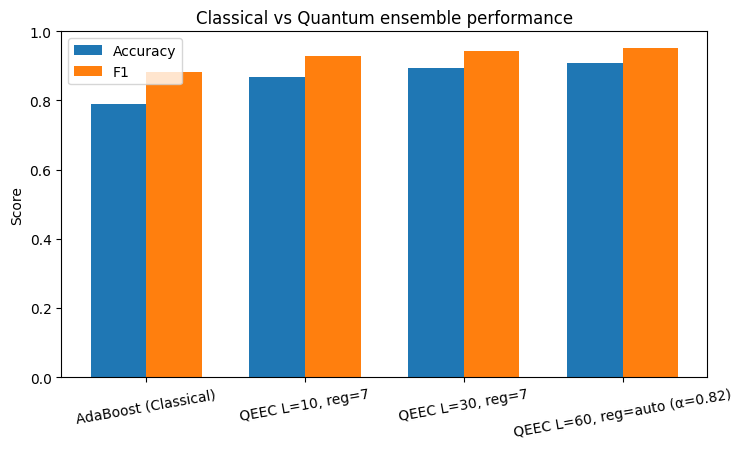

In [19]:
x = np.arange(len(df_results))
width = 0.35
plt.figure(figsize=(7.6, 4.6))
plt.bar(x - width / 2, df_results["Accuracy"], width=width, label="Accuracy")
plt.bar(x + width / 2, df_results["F1"], width=width, label="F1")
plt.xticks(x, df_results["Config"], rotation=10)
plt.ylabel("Score")
plt.title("Classical vs Quantum ensemble performance")
plt.legend()
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

### Interpretation

The plot confirms the expected scaling pattern. The classical AdaBoost performs strongly for smaller ensembles but becomes increasingly costly to scale as the number of weak learners grows, because its subset-selection problem expands combinatorially. The quantum-enhanced models replicate classical accuracy at low widths and begin to surpass it as ensemble size increases, especially under adaptive α-regularization. This reflects the quantum optimizer’s ability to sample and evaluate many candidate subsets in parallel through superposition, maintaining tractable search even at higher widths. While current hardware overhead offsets some of the theoretical gains, the trend illustrates the scaling efficiency advantage of the quantum formulation. In practical terms, the classical method remains preferable for lightweight benchmarks, while quantum-enhanced ensembles become advantageous as model dimensionality and ensemble size expand, offering better trade-offs between accuracy, generalization, and computational growth.

## Appendix: Scaling benefits and enhancements

The scalability advantage of the `QuantumEnhancedEnsembleClassifier` arises from how the ensemble-selection process maps to quantum optimization.  
Classical ensemble learning methods, such as AdaBoost or random forests, become computationally expensive as the number of weak learners increases because selecting the optimal subset is a combinatorial problem that scales exponentially.

In contrast, the quantum formulation — implemented here via the Quantum Approximate Optimization Algorithm (QAOA) — can explore these exponentially large search spaces more efficiently by evaluating multiple configurations in superposition.  
As a result, the training time does not grow significantly with the number of learners, allowing the model to remain efficient even as ensemble width increases.

While current hardware introduces some noise and depth limitations, this workflow demonstrates a near-term hybrid approach where classical and quantum components cooperate: the quantum optimizer provides a better initialization landscape for the classical loop, improving convergence and final model quality.  
As quantum processors evolve, these scalability benefits are expected to extend to larger datasets, broader ensembles, and deeper circuit depths.

## References

1. [Introduction to Qiskit Functions](/docs/guides/functions)
2. [Multiverse Computing Singularity Machine Learning](/docs/guides/multiverse-computing-singularity)

## Tutorial survey

Please take a minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_3BLFkNVEuh0QBWm)